In [1]:
# References:
# https://github.com/marshackVB/ml-recipes/blob/master/PandasUDF_Hyperopt_Spark.ipynb
# https://www.phdata.io/blog/bayesian-hyperparameter-optimization-with-mlflow/
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, DateType, FloatType
from pyspark.sql.functions import *

# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '10gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

import os
from functions.func import *

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# Load models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.arima import AutoARIMA

# 1. Paramaters

In [3]:
!python --version

Python 3.10.5


In [4]:
experiment_name = "forecast_pyspark"
days_to_forecast = 14
last_train_date = date(2021, 12, 31)
use_sample_data = True
multiple_models = True # Currently Xgboost and RandomForest

if not multiple_models:
    model_name = 'xgboost'  # 'randomforest'
    model = XGBRegressor if model_name == 'xgboost' else RandomForestRegressor

# 2. Data Input

In [5]:
df_input = sqlContext.read.parquet("sample_data/sample_data.parquet")

In [6]:
if not use_sample_data:
    # to read parquet file
    df_input = sqlContext.read.parquet('data/forecast_encoded_data.parquet')
    df_input = df_input.filter( ( col('Key1') == 'N01') & (col('Key2').isin(['76', '62']) ) )

    unique_ts = df_input_train.select(['Key1', 'Key2']).drop_duplicates().toPandas()
    
label_col = 'y'
feature_cols = [column for column in df_input.columns if column not in [label_col, 'ds', 'Forecast', 'Key1','Key2']]

df_input_train = df_input.filter(col('ds') <= last_train_date )
df_input_test = df_input.filter(col('ds') > last_train_date )

In [7]:
check_key1 = 'N01'
check_key2 = '76'
df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) & (col('ds') > '2021-11-01')  ).sort(col('ds')).show()

length_ts = df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) ).toPandas().shape[0]

+----+----+-------------------+----+-----+---------+---+
|Key1|Key2|                 ds|year|month|dayofweek|  y|
+----+----+-------------------+----+-----+---------+---+
| N01|  76|2021-11-02 00:00:00|2021|   11|        3|100|
| N01|  76|2021-11-03 00:00:00|2021|   11|        4|189|
| N01|  76|2021-11-04 00:00:00|2021|   11|        5|313|
| N01|  76|2021-11-05 00:00:00|2021|   11|        6|311|
| N01|  76|2021-11-06 00:00:00|2021|   11|        7| 59|
| N01|  76|2021-11-07 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-08 00:00:00|2021|   11|        2|221|
| N01|  76|2021-11-09 00:00:00|2021|   11|        3|228|
| N01|  76|2021-11-10 00:00:00|2021|   11|        4| 72|
| N01|  76|2021-11-11 00:00:00|2021|   11|        5|335|
| N01|  76|2021-11-12 00:00:00|2021|   11|        6|302|
| N01|  76|2021-11-13 00:00:00|2021|   11|        7| 70|
| N01|  76|2021-11-14 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-15 00:00:00|2021|   11|        2|166|
| N01|  76|2021-11-16 00:00:00|

# 3. Model Training

In [8]:
# df = df_input_train.toPandas()
y = df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) ).toPandas().reset_index(drop=True)['y'].copy()

In [9]:

# Timeseries-based Algorithm CV Cross Validator
fh = [x for x in range(1,days_to_forecast +1)]
n_cv = 2
step_length = 1
initial_window = length_ts - (len(fh) + n_cv*step_length -1)
cv_ts = ExpandingWindowSplitter(initial_window = initial_window, step_length=step_length, fh=fh)

# Treee-based algorithms CV Cross validator
cv_tree = TimeSeriesSplit(n_splits=n_cv,test_size=days_to_forecast)

cv_objects = {
      'tree_algo': cv_tree,
      'ts_algo': cv_ts,
    
}

# Hyperopt search space
search_space = {
  'tree_algo':{
      'n_estimators':scope.int(hp.uniform('n_estimators',50,300)),
      'max_depth':scope.int(hp.uniform('max_depth',3,15)),
      #'min_samples_leaf':scope.int(hp.uniform('min_samples_leaf',1,5)),
      #'min_samples_split':scope.int(hp.uniform('min_samples_split',2,6)), #num_features_for_split = sqrt(total_input_features)
      #'max_samples': hp.uniform("max_samples",0.5, 1)
  },
    'ts_algo':{
        "sp":scope.int(hp.uniform('n_estimators',7,10)), 
        #d=scope.int(hp.uniform('n_estimators',1,2)), 
        #max_p=scope.int(hp.uniform('n_estimators',1,3)), 
        #max_q=scope.int(hp.uniform('n_estimators',1,3)),
    }
}


In [10]:
for train_index, test_index in cv_ts.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 1078 1079 1080] TEST: [1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094]
TRAIN: [   0    1    2 ... 1079 1080 1081] TEST: [1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095]


In [13]:
# Pandas_UDF requires a Spark Schema that matches the output of the UDF
fit_schema = StructType([StructField('node', StringType(), True),
                         StructField('best_model_score', DoubleType(), True)])


if multiple_models:
    
    fit_multiple_models_config = fit_multiple_models(feature_cols = feature_cols, 
                               label_col = label_col,
                               models = [AutoARIMA], #[XGBRegressor, RandomForestRegressor ],
                               search_space = search_space,
                               days_to_forecast = days_to_forecast,
                               cv_objects=cv_objects,
                               experiment_name = experiment_name,
                               scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                               
                                )

    best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_multiple_models_config, schema = fit_schema)
    
else:
    

    fit_models = fit_models_config(feature_cols = feature_cols, 
                                   label_col = label_col,
                                   model = model,
                                   search_space = search_space,
                                   days_to_forecast = days_to_forecast,
                                   experiment_name = experiment_name,
                                   scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                                   cv=cv
                                    )

    best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_models,schema=fit_schema)

In [14]:
%%time
best_model_stats.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [12]:
%%time
best_model_stats.show()

+------+----------------+
|  node|best_model_score|
+------+----------------+
|N01_62|          0.4417|
|N01_76|          0.7168|
+------+----------------+

CPU times: user 9.66 ms, sys: 16.2 ms, total: 25.9 ms
Wall time: 1min 51s


## 3. Model Evaluation

In [11]:
# Define the schema for the UDF's output DataFrame
forecast_schema =StructType([
  StructField('ds',DateType()),
  StructField('Key1',StringType()),
  StructField('Key2',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_lower',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('run_id',StringType())
  ])

experiment_id = '1'
apply_models = apply_models_config(features_cols = feature_cols,  experiment_id=experiment_id)

# 4. Plot

In [15]:
check_key1 = 'N01' # N01_62
check_key2 = '76'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

In [12]:


# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()


In [16]:
runs_df = mlflow.search_runs(experiment_id, order_by=["metrics.smape"])

In [18]:
runs_df.sort_values(by = ['end_time'])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.smape,params.n_estimators,params.max_depth,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.model_type,tags.ts_key
5,de9537252ad1402e88ad03013df1efba,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/de...,2022-09-25 15:42:28.496000+00:00,2022-09-25 15:42:45.021000+00:00,0.6995,94.2683497996652,3.8534088815992473,unique-tern-867,jovyan,LOCAL,"[{""run_id"": ""de9537252ad1402e88ad03013df1efba""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,XGBRegressor,N01_62
0,879e3bcede5d4b06b4e4937857bc98a3,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/87...,2022-09-25 15:42:45.023000+00:00,2022-09-25 15:43:24.437000+00:00,0.4382,57.80399309715773,3.6053634511924026,gifted-newt-460,jovyan,LOCAL,"[{""run_id"": ""879e3bcede5d4b06b4e4937857bc98a3""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,RandomForestRegressor,N01_62
9,03677149e558428fb6f9bc4663310aee,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/03...,2022-09-25 15:43:24.448000+00:00,2022-09-25 15:43:37.307000+00:00,0.9896,76.98299352384045,3.6304201088698695,lyrical-bass-566,jovyan,LOCAL,"[{""run_id"": ""03677149e558428fb6f9bc4663310aee""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,XGBRegressor,N01_76
6,a4669314da3748808f33557f946a4aab,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/a4...,2022-09-25 15:43:37.311000+00:00,2022-09-25 15:44:23.843000+00:00,0.7159,218.79490056396136,4.567961735551368,placid-goose-128,jovyan,LOCAL,"[{""run_id"": ""a4669314da3748808f33557f946a4aab""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,RandomForestRegressor,N01_76
13,4ae8f63c79594847ad829c707508a502,1,FAILED,file:///home/jovyan/work/notebooks/mlruns/1/4a...,2022-09-25 17:26:00.897000+00:00,2022-09-25 17:26:00.908000+00:00,NaN,None,None,exultant-stork-439,jovyan,LOCAL,None,/usr/local/spark/python/lib/pyspark.zip/pyspar...,None,None
4,b0cde4fbfd414511aa59c23d00121bbd,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/b0...,2022-09-25 17:29:03.049000+00:00,2022-09-25 17:29:16.685000+00:00,0.6995,94.2683497996652,3.8534088815992473,exultant-ox-281,jovyan,LOCAL,"[{""run_id"": ""b0cde4fbfd414511aa59c23d00121bbd""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,XGBRegressor,N01_62
1,abf83ab114f046c6b95ed2196beaef61,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/ab...,2022-09-25 17:29:16.687000+00:00,2022-09-25 17:29:52.136000+00:00,0.4411,94.00072836795769,3.032767041929552,clumsy-skunk-170,jovyan,LOCAL,"[{""run_id"": ""abf83ab114f046c6b95ed2196beaef61""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,RandomForestRegressor,N01_62
12,7be22174027e468381a6e8f256e0015e,1,FAILED,file:///home/jovyan/work/notebooks/mlruns/1/7b...,2022-09-25 17:29:52.138000+00:00,2022-09-25 17:29:52.146000+00:00,NaN,None,None,nebulous-shark-671,jovyan,LOCAL,None,/usr/local/spark/python/lib/pyspark.zip/pyspar...,None,None
3,fbe43c7156294269b20f5ef1789b8160,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/fb...,2022-09-25 18:24:11.924000+00:00,2022-09-25 18:24:33.145000+00:00,0.6995,94.2683497996652,3.8534088815992473,bouncy-zebra-490,jovyan,LOCAL,"[{""run_id"": ""fbe43c7156294269b20f5ef1789b8160""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,XGBRegressor,N01_62
2,bfd46df57768456a870396e52ede5251,1,FINISHED,file:///home/jovyan/work/notebooks/mlruns/1/bf...,2022-09-25 18:24:33.147000+00:00,2022-09-25 18:25:09.079000+00:00,0.4417,107.65618409669997,3.9915077585633236,zealous-finch-567,jovyan,LOCAL,"[{""run_id"": ""bfd46df57768456a870396e52ede5251""...",/usr/local/spark/python/lib/pyspark.zip/pyspar...,RandomForestRegressor,N01_62


In [15]:
model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

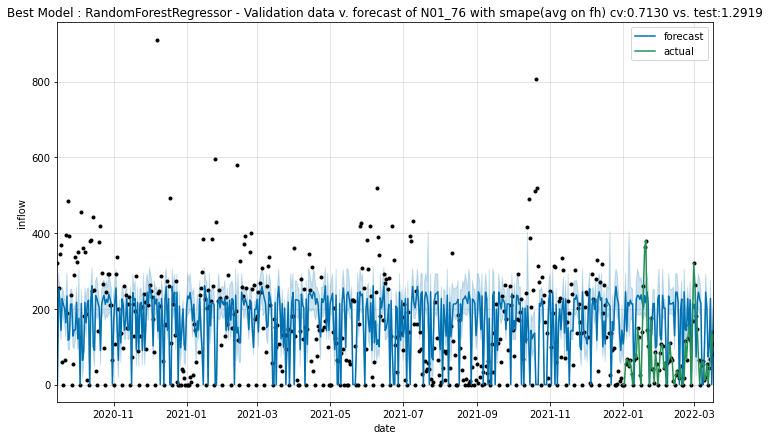

In [16]:
best_model_name = best_run_df['tags.model_type'].values[0]
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name, best_model_name )

In [17]:
check_key1 = 'N01' # N01_62
check_key2 = '62'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

# extract the forecast for a specific ts_key as example
forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()

model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

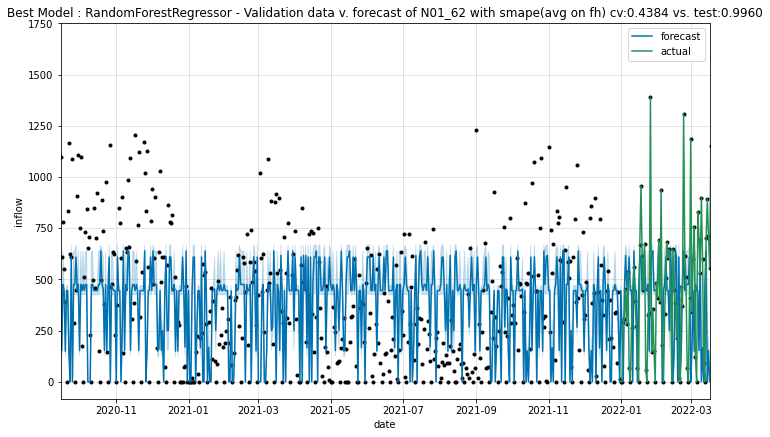

In [18]:
best_model_name = best_run_df['tags.model_type'].values[0]
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name, best_model_name )